In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import yaml
import statsmodels.api as sm
import seaborn as sns
from scipy.interpolate import interp1d
import pickle
import numpy as np
sys.path.append('/home/xfang2/repos/celldetection')
import sma
from scipy.integrate import solve_ivp
import pandas as pd

In [3]:
# dydt function
def dydt(t,y,params):
    cyto, ER1, ER2=y
    
    Vmserca=params['Vmserca']
    Kdserca=params['Kdserca']
    kRyr=params['kRyr']
    kshuttle=params['kcomp']
    
    dcytodt = kRyr*ER2 -  Vmserca/(1+(Kdserca/cyto)**2)
    dER1dt = Vmserca/(1+(Kdserca/cyto)**2) - kshuttle*ER1
    dER2dt = kshuttle*ER1 - kRyr*ER2
    
    return [dcytodt,dER1dt,dER2dt]

# normalization function
def minmax_scaling(data):
    data-=np.min(data)
    data/=np.max(data)
    
    return data

In [4]:
# reorder MC traces based on reference param
def reorder(df,ref_param=None,paramList=None,K=3,nChains=5):
    orders=[]
    reordered_vals=np.zeros((0,K))
    for chain in range(nChains):
        orders_chain=[]
        vals=[]
        for k in range(K):
            trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(ref_param,k,k)]
            vals.append(trace)
        vals=np.array(vals).T
        # reordering
        reordered=np.zeros_like(vals)
        for i in range(len(trace)):
            order = np.argsort(vals[i])
            reordered[i] = vals[i][order]
            orders_chain.append(order)
        orders.append(orders_chain)
        reordered_vals=np.append(reordered_vals,reordered,axis=0)
    for k in range(K):
        df['{}[{}]'.format(ref_param,k)]=reordered_vals[:,k]
    
    # apply reordering on other params
    for param in paramList:
        if param==ref_param:
            continue
        reordered_vals=np.zeros((0,K))
        for chain in range(nChains):
            vals=[]
            for k in range(K):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,k,k)]
                vals.append(trace)
            vals=np.array(vals).T 
            # reordering
            reordered=np.zeros_like(vals)
            for i in range(len(trace)):
                order = orders[chain][i]
                reordered[i] = vals[i][order]
            reordered_vals=np.append(reordered_vals,reordered,axis=0)
        for k in range(K):
            df['{}[{}]'.format(param,k)]=reordered_vals[:,k]


In [5]:
## NOTE: initially some of the params were name differently
## kSC: kSERCA, kcomp: kshuttle
hypers_mu={
    'sim':{'mu_Vmserca': 1.5, 'mu_Kdserca':5.0e-1,'mu_kRyr': 2.0e-2, 'mu_kcomp': 1.0},
    'expt':{'mu_Vmserca': 1.5, 'mu_Kdserca':5.0e-1, 'mu_kRyr': 2.0e-2, 'mu_kcomp': 2.0e-1}}
hypers_sigma={
    'sim':{'mu_Vmserca': 1.0e-1, 'mu_Kdserca':1.0e-1,'mu_kRyr': 1.0e-1, 'mu_kcomp': 1.0e-1},
    'expt':{'mu_Vmserca': 1.0e-1, 'mu_Kdserca':1.0e-1, 'mu_kRyr': 1.0e-1, 'mu_kcomp': 1.0e-1}}
hyperParams=['mu_Vmserca','mu_Kdserca','mu_kRyr','mu_kcomp']
params=['Vmserca','Kdserca','kRyr','kcomp']
paramList=['w','mu_Vmserca','mu_Kdserca','mu_kRyr','mu_kcomp','sigma_Vmserca','sigma_Kdserca','sigma_kRyr','sigma_kcomp']
hyperLabels=['mu_V$_{max,SERCA}$', 'mu_K$_{d,SERCA}$','mu_k$_{Ryr}$', 'mu_k$_{shuttle}$']
labels=['V$_{max,SERCA}$', 'K$_{d,SERCA}$','k$_{Ryr}$', 'k$_{shuttle}$']
cell_cols1=['lightblue','paleturquoise','aqua','turquoise','mediumturquoise','mediumspringgreen','springgreen','palegreen','chartreuse','greenyellow','lime','limegreen']
cell_cols2=['palegoldenrod','khaki','gold','moccasin','navajowhite','orange','lightsalmon','coral','salmon','lightcoral','tomato','indianred']
k_cols=['lightskyblue','deepskyblue','royalblue']


In [6]:
# data to fit
exptFile='/home/xfang2/repos/bayes/data/observed_data/cyto_ER_shuttling/expt_data.csv'
simFile='/home/xfang2/repos/bayes/data/observed_data/cyto_ER_shuttling/sim_data.csv'
simData=np.genfromtxt(simFile, delimiter=',')  
exptData=np.genfromtxt(exptFile, delimiter=',')  
keys=['sim','expt']
frameRate={'sim':0.05,'expt':3.0e-2} # sec/frame
nChains=5
normalize=True
K=3
nChannels=2
nCells={'sim':int(simData.shape[1]/2),'expt':int(exptData.shape[1]/2)}
obs_data={}

for key in keys:
    file='/home/xfang2/repos/bayes/data/observed_data/cyto_ER_shuttling/{}_data.csv'.format(key)
    raw_data=np.genfromtxt(file, delimiter=',')  
    datDict={}
    dat1=[]
    dat2=[]
    n=nCells[key]
    for cell in range(n):
        channel1=raw_data[:,cell]
        channel2=raw_data[:,cell*nChannels+1]
        dat1.append(channel1)
        dat2.append(channel2)
    datDict['cyto']=dat1
    datDict['ER']=dat2
    obs_data[key]=datDict

## analysis

In [8]:
# load inference data
path='/home/xfang2/repos/bayes/data/inference_data/cyto_ER_shuttling'
model=3
infData={}
infData['sim']=[]
infData['expt']=[]

file=path+'/model{}_trace_sim.csv'.format(model)
if os.path.isfile(file):
    df=pd.read_csv(file)
    reorder(df,ref_param='mu_kcomp',paramList=paramList,K=3,nChains=5)
    infData['sim']=df
else:
    print('missing {}'.format(file))
file=path+'/model{}_trace_expt.csv'.format(model)
if os.path.isfile(file):
    df=pd.read_csv(file)
    reorder(df,ref_param='mu_kcomp',paramList=paramList,K=3,nChains=5)
    infData['expt']=df
else:
    print('missing {}'.format(file))


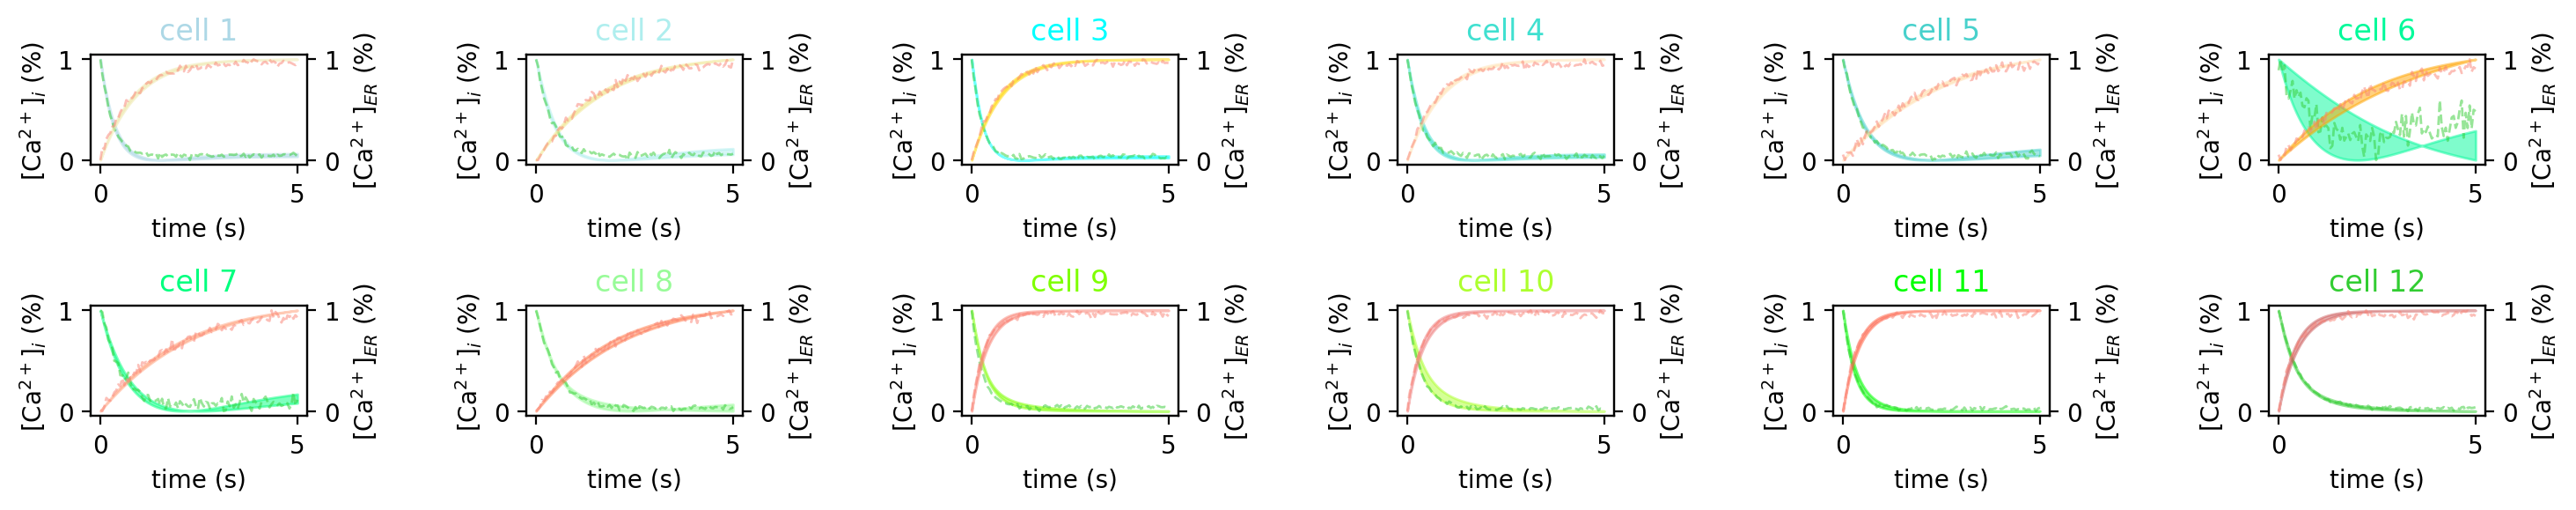

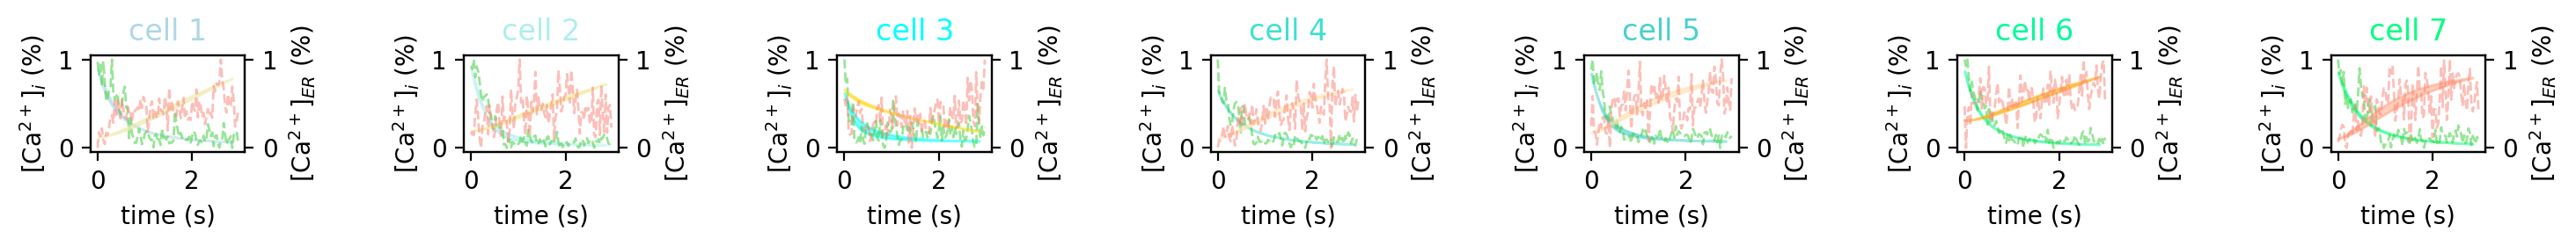

In [15]:
# fit
rcParams['figure.figsize']=15,5
rcParams['font.size']=10
rcParams['figure.dpi']=200
normalize=True

for key in obs_data.keys():
    if key=='expt':
        rcParams['figure.figsize']=15,1.5
    else:
        rcParams['figure.figsize']=15,3
        
    n=nCells[key]
    df=infData[key]
    
    fig=plt.figure()
    for cell in range(n):
        if key=='expt':
            ax=fig.add_subplot(1,7,cell+1)
        else:
            ax=fig.add_subplot(2,6,cell+1)
            
        axr=ax.twinx()
        ax.set_title('cell {}'.format(cell+1),color=cell_cols1[cell])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('[Ca$^{2+}$]$_i$ (%)')
        axr.set_ylabel('[Ca$^{2+}$]$_{ER}$ (%)')
        
        channel1=obs_data[key]['cyto'][cell]
        channel2=obs_data[key]['ER'][cell]
        channel1=minmax_scaling(channel1)
        channel2=minmax_scaling(channel2)
        
        # raw data
        stepSize=len(channel1)
        ts=np.linspace(0,stepSize*frameRate[key],stepSize) 
        ax.plot(ts,channel1,lw=1,color='limegreen',label='observed',alpha=0.5,linestyle='--')  
        axr.plot(ts,channel2,lw=1,color='salmon',label='observed',alpha=0.5,linestyle='--')  
        
        # run sma on experimental data
        if key == 'expt':
            # sma
            window1=window2=5
            channel1=sma.sma(window1,channel1)
            channel2=sma.sma(window2,channel2)
            stepSize1=len(channel1)
            ts=np.linspace(0,stepSize1*frameRate[key],stepSize1)
            stepSize2=len(channel2)
            ts2=np.linspace(0,stepSize2*frameRate[key],stepSize2)
            # to ensure the two channels have the same time steps, we interpolate channel2 over the time steps of channel1
            interp_func=interp1d(ts2,channel2,fill_value='extrapolate')
            channel2=interp_func(ts)              
        
        y01=channel1[0]
        y02=channel2[0]
        
        channel1Min,channel1Max,channel2Min,channel2Max=np.min(channel1),np.max(channel1),np.min(channel2),np.max(channel2)
        
        varDict,varDictLower,varDictUpper={},{},{}
        for i,param in enumerate(params):
            vals=np.array([]) # array to combine all chains
            for chain in range(nChains):  
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                vals=np.append(vals,trace)
            N=len(vals)
            avg, lower, upper=np.mean(vals), np.sort(vals)[ int(0.05*N) ], np.sort(vals)[ int(0.95*N) ]
            varDict[param],varDictLower[param],varDictUpper[param]=avg,lower,upper

        if key == 'sim':
            y0s=[y01, 10., y02]
        else:
            y0s=[y01, 0.1, y02]
        ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDict,),t_eval=ts,method='LSODA').y
        sim1,sim2=ys[0],ys[2] 
        ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDictLower,),t_eval=ts,method='LSODA').y
        sim1Lower,sim2Lower=ys[0],ys[2]  
        ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDictUpper,),t_eval=ts,method='LSODA').y
        sim1Upper,sim2Upper=ys[0],ys[2]  

        # normalization
        sim1=minmax_scaling(sim1)
        sim2=minmax_scaling(sim2)
        sim1Lower=minmax_scaling(sim1Lower)
        sim2Lower=minmax_scaling(sim2Lower)
        sim1Upper=minmax_scaling(sim1Upper)
        sim2Upper=minmax_scaling(sim2Upper)

        # rescale
        sim1=sim1*(channel1Max-channel1Min)+channel1Min
        sim2=sim2*(channel2Max-channel2Min)+channel2Min
        sim1Lower=sim1Lower*(channel1Max-channel1Min)+channel1Min
        sim2Lower=sim2Lower*(channel2Max-channel2Min)+channel2Min
        sim1Upper=sim1Upper*(channel1Max-channel1Min)+channel1Min
        sim2Upper=sim2Upper*(channel2Max-channel2Min)+channel2Min

        # area
        #ax.plot(ts,sim1Lower,color='limegreen',lw=0.5)
        #ax.plot(ts,sim1Upper,color='limegreen',lw=0.5)
        ax.fill_between(ts,sim1Lower,sim1Upper,alpha=0.5,color=cell_cols1[cell], label='95% CI')
        #axr.plot(ts,sim2Lower,color='salmon',lw=0.5)
        #axr.plot(ts,sim2Upper,color='salmon',lw=0.5)
        axr.fill_between(ts,sim2Lower,sim2Upper,alpha=0.5,color=cell_cols2[cell], label='95% CI')
            
    plt.tight_layout()
    plt.savefig('model{}_fit_{}.png'.format(model,key))



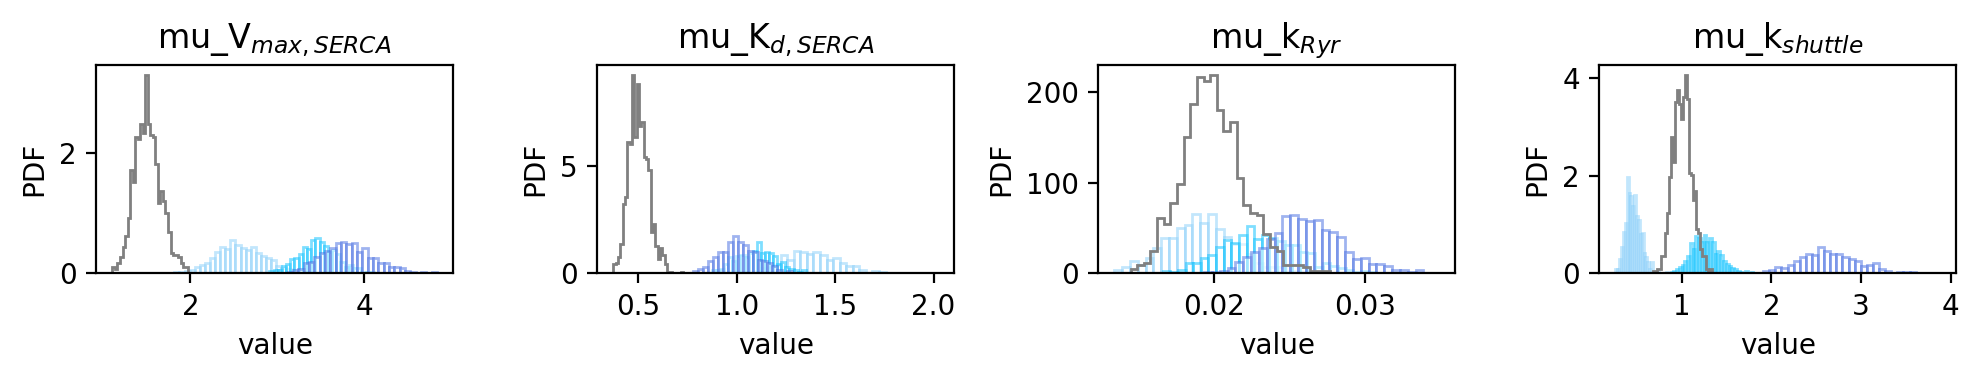

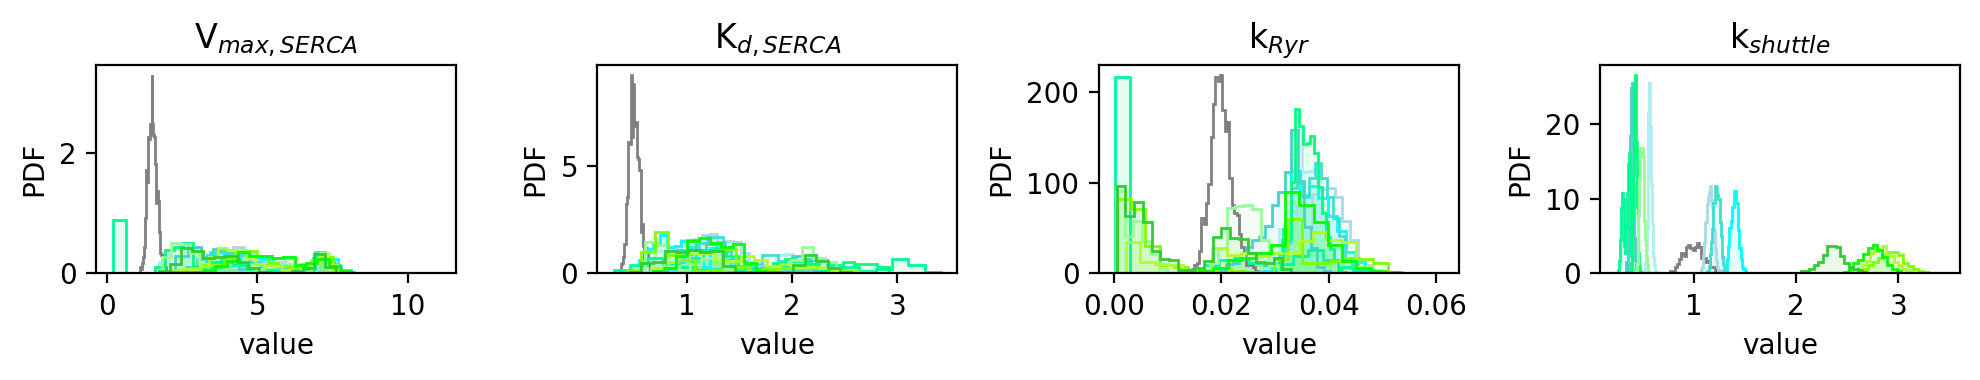

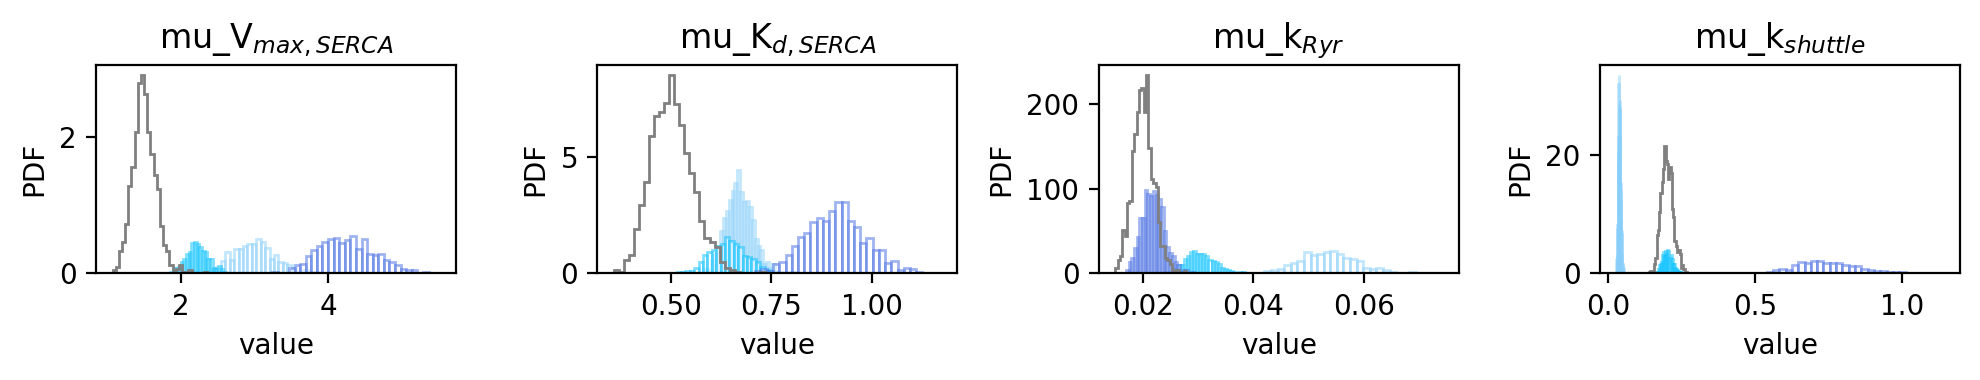

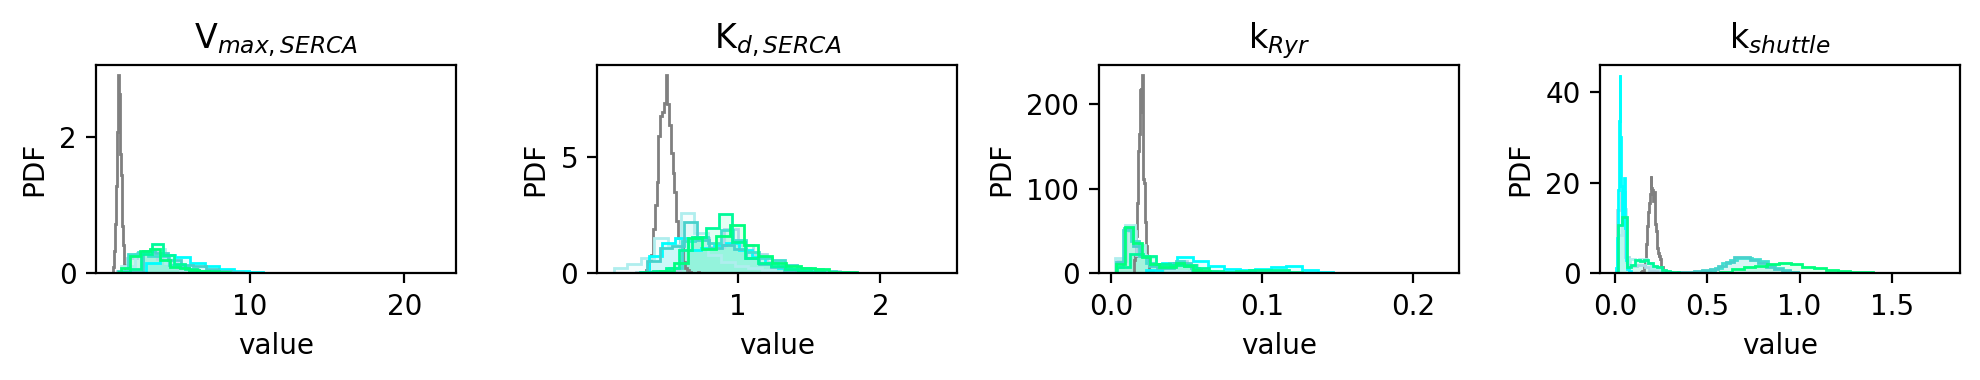

In [10]:
# posterior
rcParams['figure.dpi']=200
rcParams['font.size']=10
priors={}

for key in obs_data.keys():
    df=infData[key]
    n=nCells[key]
    
    # hypers
    fig=plt.figure(figsize=(10,2))  
    for i,param in enumerate(params):    
        ax=fig.add_subplot(1,4,i+1)
        ax.set_title(hyperLabels[i])
        ax.set_xlabel('value')
        ax.set_ylabel('PDF')
        
        prs=[]
        for iteration in range(1000):
            pr=np.random.lognormal(mean=np.log(hypers_mu[key]['mu_{}'.format(param)]),sigma=hypers_sigma[key]['mu_{}'.format(param)])
            prs.append(pr)
        priors['mu_{}'.format(param)]=prs
        histPr=ax.hist(prs,bins=30,density=True,histtype='step',color='gray')      
        for k in range(K):
            mu_vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "mu_{}[{}]".format(param,k,k)]
                mu_vals=np.append(mu_vals,trace)
            w_vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "w[{}]".format(k)]
                w_vals=np.append(w_vals,trace)
            sigma_vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "sigma_{}[{}]".format(param,k,k)]
                sigma_vals=np.append(sigma_vals,trace)
            w=np.mean(w_vals)
            mu=np.mean(mu_vals)
            sigma=np.mean(sigma_vals)
            #ps=np.random.normal(mu,sigma,size=n)
            ps=np.random.lognormal(mean=np.log(mu),sigma=sigma,size=1000)
            nbin=30
            p,xs=np.histogram(ps,bins=nbin,density=True)
            new_p=p*w
            bin_widths = np.diff(xs)
            bin_centers = xs[:-1] + bin_widths / 2
            plt.bar(bin_centers, new_p, width=bin_widths, alpha=0.5, edgecolor=k_cols[k],color='white')
            
            
    plt.tight_layout()
    plt.savefig('model{}_posterior_{}_hyper.png'.format(model,key))
    
    # params
    fig=plt.figure(figsize=(10,2))  
    for i,param in enumerate(params):    
        ax=fig.add_subplot(1,4,i+1)
        ax.set_title(labels[i])
        ax.set_xlabel('value')
        ax.set_ylabel('PDF')
        
        prs=priors['mu_{}'.format(param)]
        histPr=ax.hist(prs,bins=30,density=True,histtype='step',color='gray')

        for cell in range(n):
            #if key == 'sim' and param in truthVals.keys():
            #    ax.axvline(truthVals[param][cell],color=cols[cell],linestyle='--',alpha=0.5,lw=1)
            vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                vals=np.append(vals,trace)
            ax.hist(vals,bins=20,color=cell_cols1[cell],density=True,histtype='step')
            ax.hist(vals,bins=20,color=cell_cols1[cell],alpha=0.1,density=True,histtype='stepfilled')
    plt.tight_layout()
    plt.savefig('model{}_posterior_{}.png'.format(model,key))



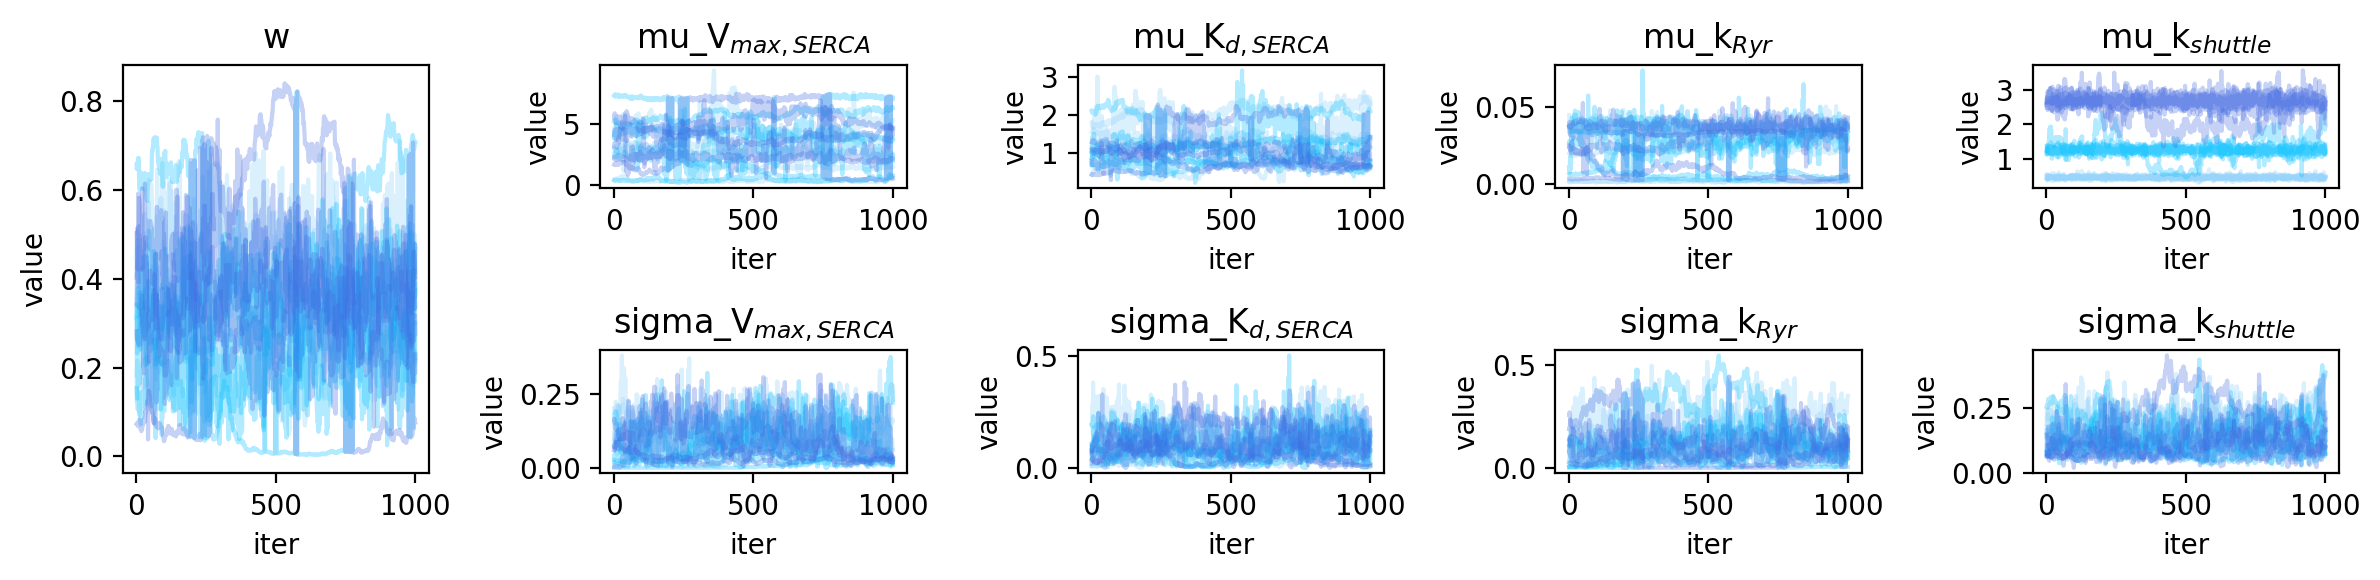

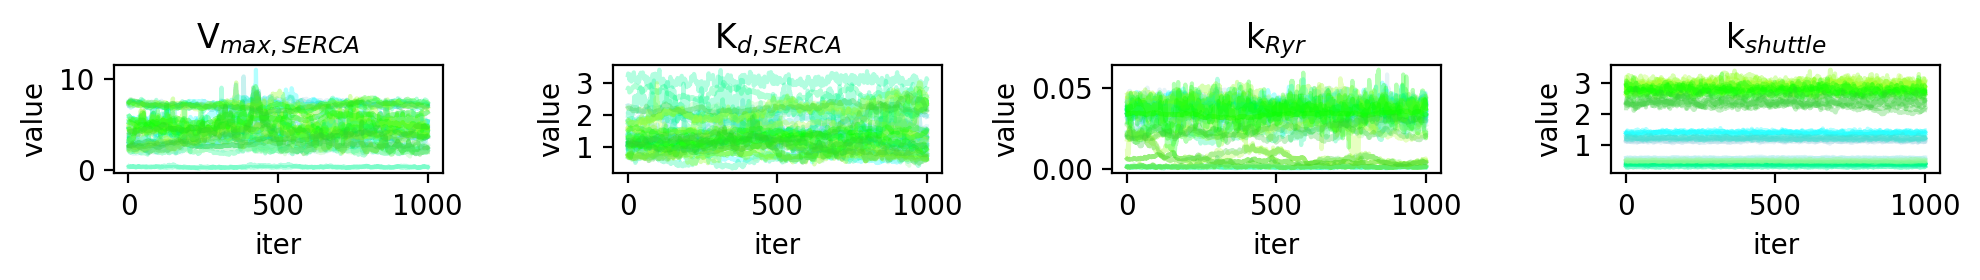

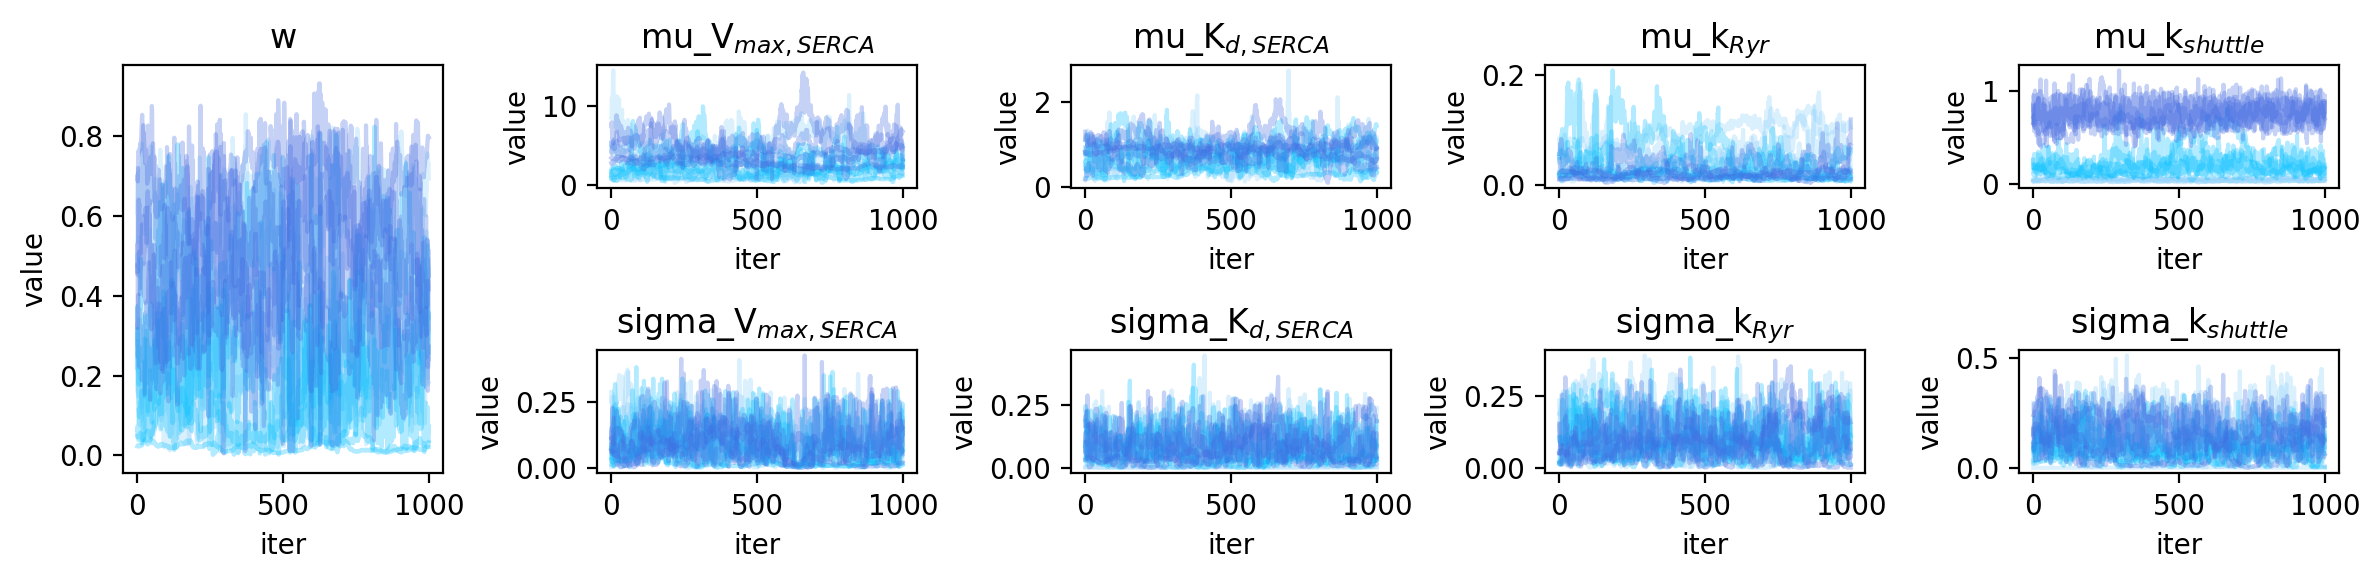

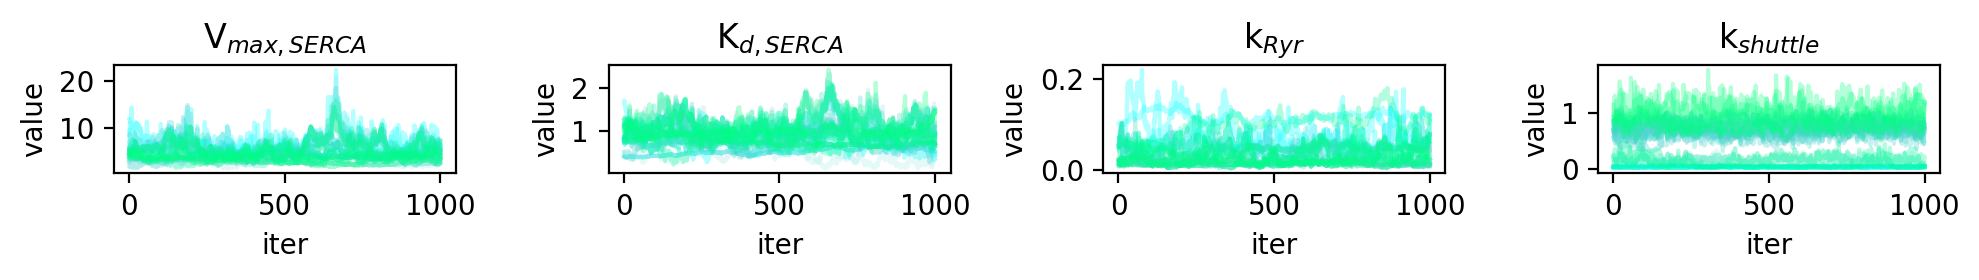

In [11]:
# trace plot
rcParams['figure.dpi']=200
rcParams['font.size']=10

for key in obs_data.keys():
    df=infData[key]
    n=nCells[key]
    
    # hypers
    fig=plt.figure(figsize=(12,3))
    
    ax=fig.add_subplot(1,5,1)
    ax.set_title('w')
    ax.set_xlabel('iter')
    ax.set_ylabel('value')

    for k in range(K):
        for chain in range(nChains):
            trace=df.loc[df['chain'] == chain, "w[{}]".format(k,k)]
            xs=range(1,len(trace)+1)
            ax.plot(xs,trace,color=k_cols[k],alpha=0.3)
                
    for i,param in enumerate(params):
        ax=fig.add_subplot(2,5,i+2)
        ax.set_title('mu_{}'.format(labels[i]))
        ax.set_xlabel('iter')
        ax.set_ylabel('value')

        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "mu_{}[{}]".format(param,k,k)]
                xs=range(1,len(trace)+1)
                ax.plot(xs,trace,color=k_cols[k],alpha=0.3)
    
    for i,param in enumerate(params):
        ax=fig.add_subplot(2,5,i+7)
        ax.set_title('sigma_{}'.format(labels[i]))
        ax.set_xlabel('iter')
        ax.set_ylabel('value')
        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "sigma_{}[{}]".format(param,k,k)]
                xs=range(1,len(trace)+1)
                ax.plot(xs,trace,color=k_cols[k],alpha=0.3)
    plt.tight_layout()
    plt.savefig('model{}_trace_{}_hyper.png'.format(model,key))
    
    # params
    fig=plt.figure(figsize=(10,1.5))
    for i,param in enumerate(params):
        ax=fig.add_subplot(1,4,i+1)
        ax.set_title(labels[i])
        ax.set_xlabel('iter')
        ax.set_ylabel('value')

        for cell in range(n):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                xs=range(1,len(trace)+1)
                ax.plot(xs,trace,color=cell_cols1[cell],alpha=0.3)
    plt.tight_layout()
    plt.savefig('model{}_trace_{}.png'.format(model,key))

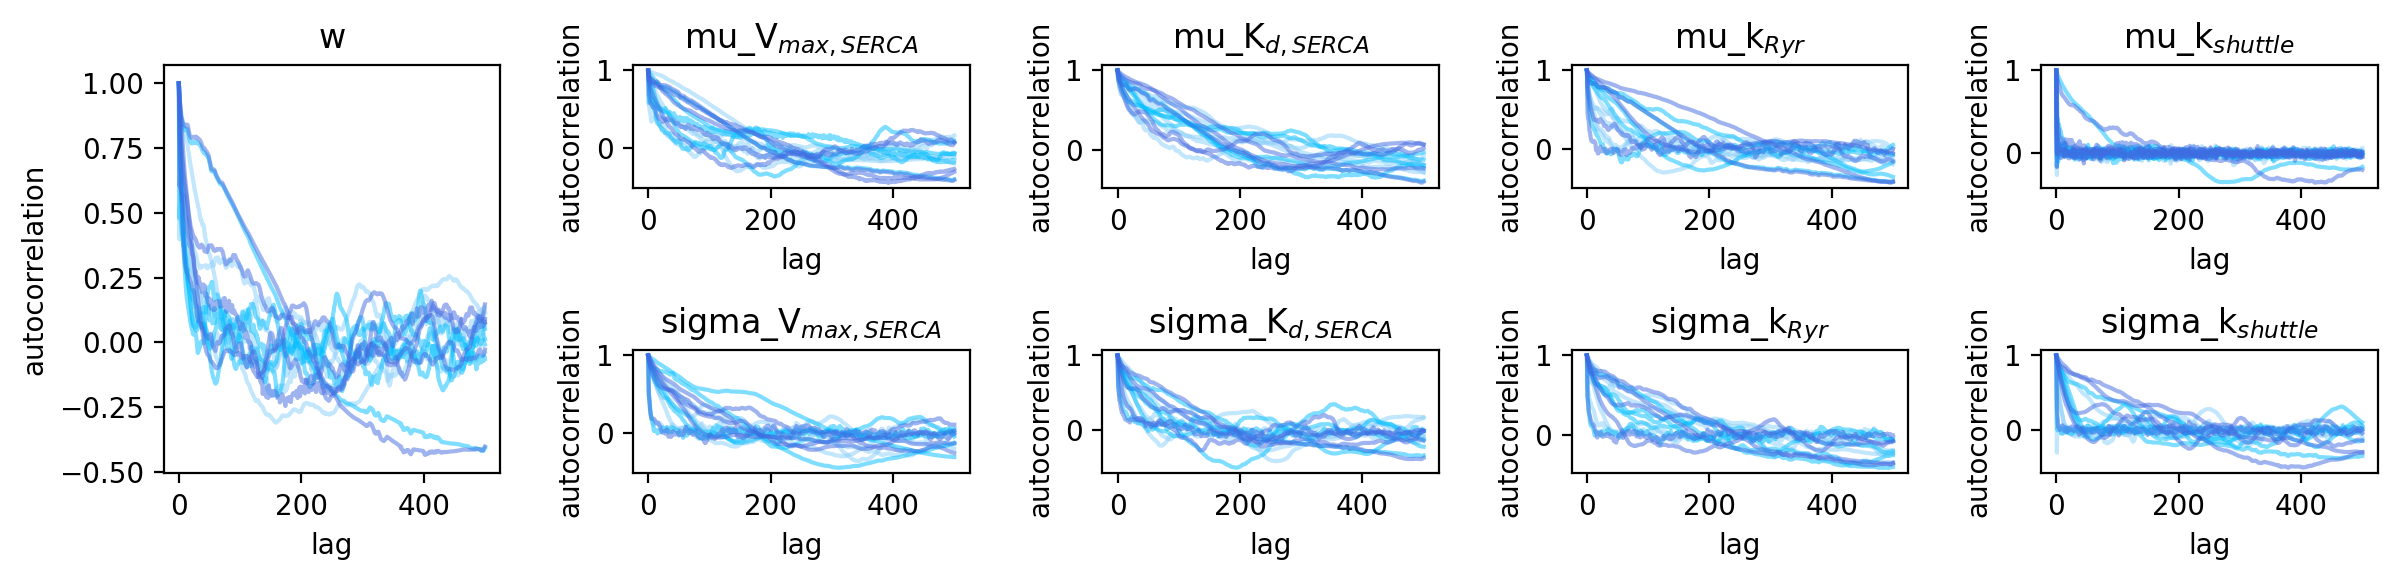

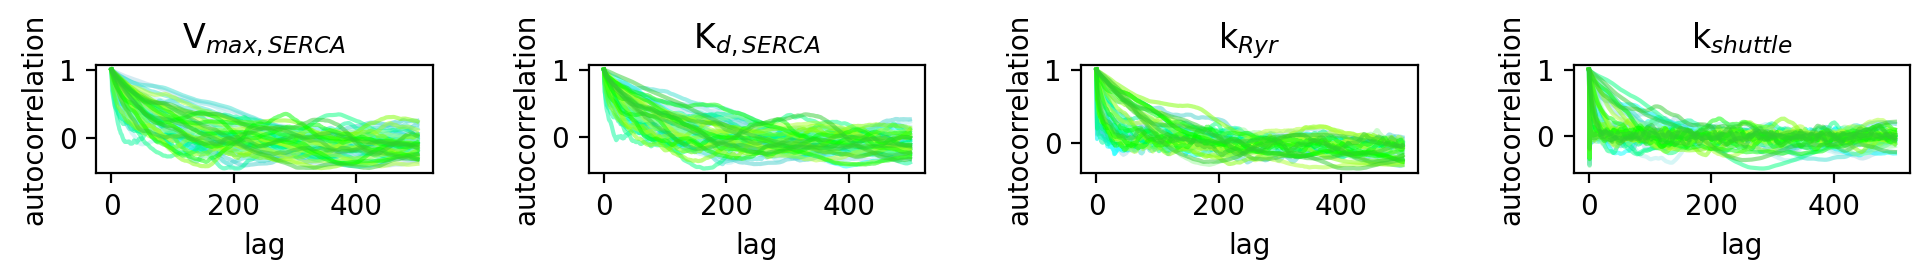

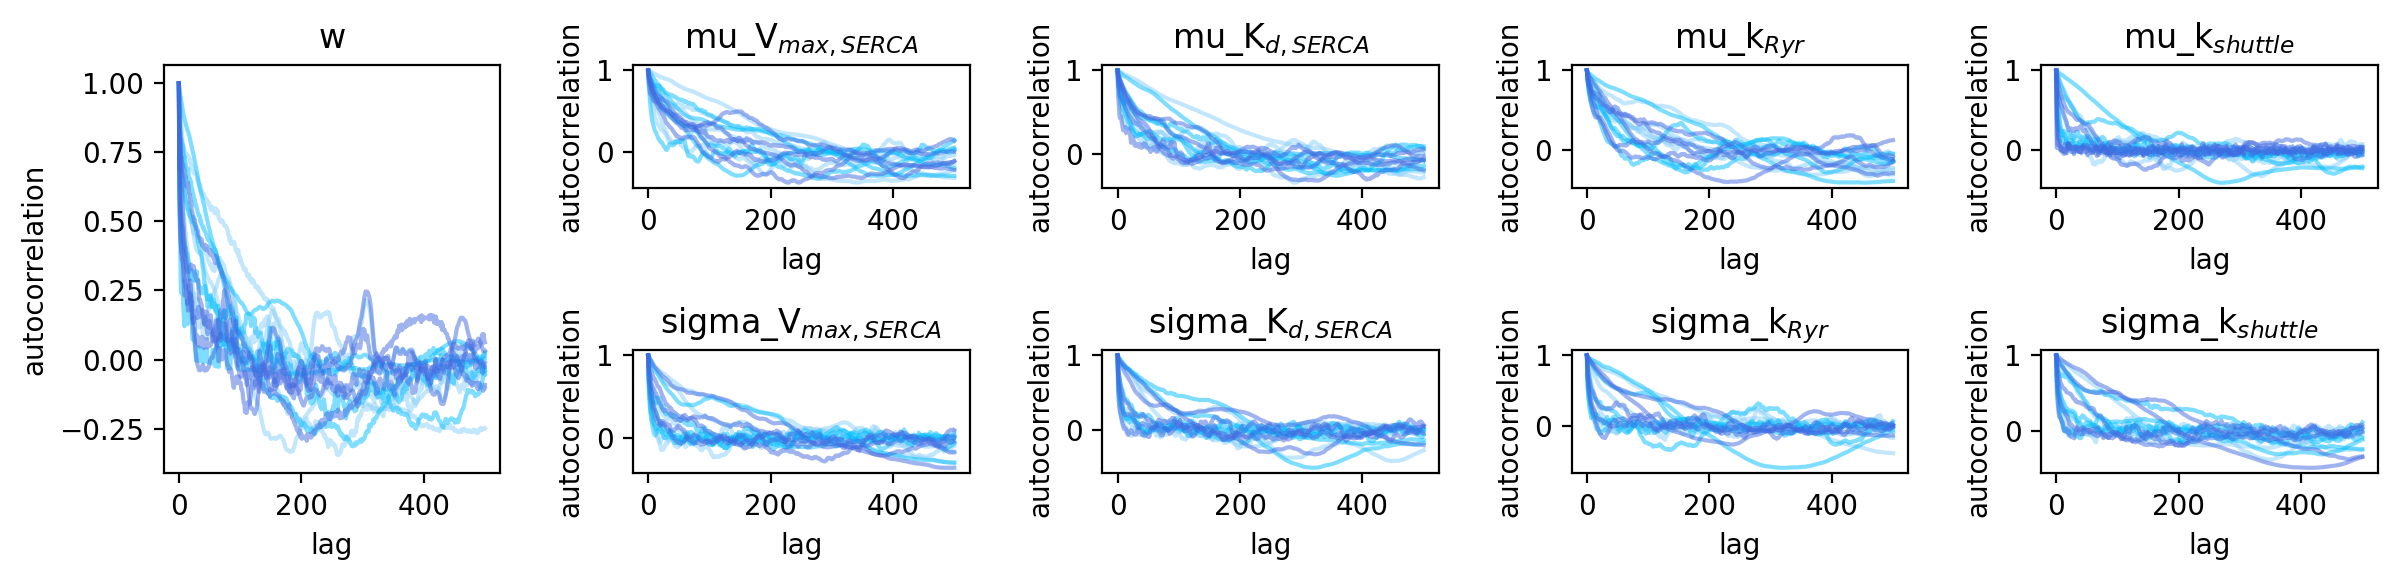

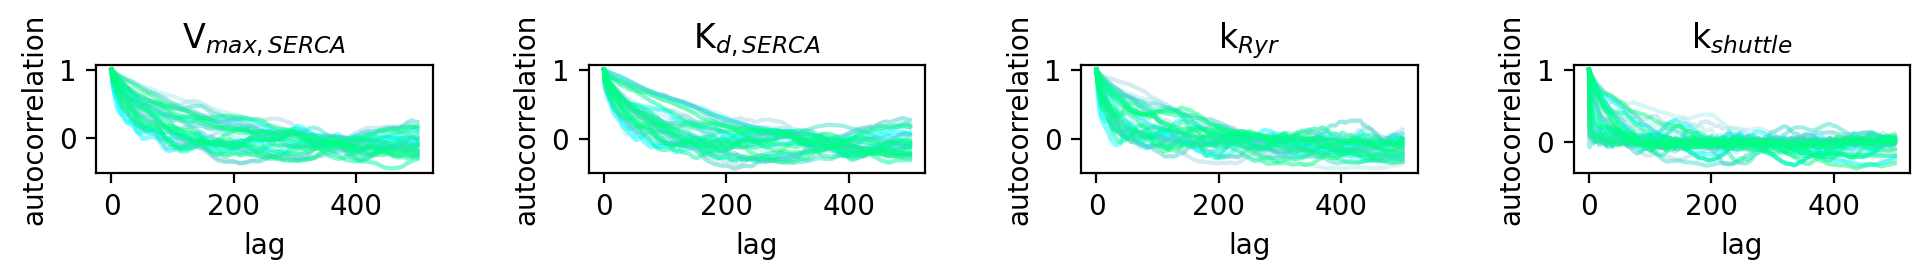

In [12]:
# autocorrelation
rcParams['figure.dpi']=200
rcParams['font.size']=10

for key in obs_data.keys():  
    df=infData[key]
    n=nCells[key]
    
    fig=plt.figure(figsize=(12,3))  
    ax=fig.add_subplot(1,5,1)
    ax.set_title('w')
    ax.set_xlabel('lag')
    ax.set_ylabel('autocorrelation')    
    for k in range(K):
        for chain in range(nChains):
            trace=df.loc[df['chain'] == chain, "w[{}]".format(k,k)]
            autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
            ax.plot(autocorr,color=k_cols[k],alpha=0.5)    
                
    for i,param in enumerate(params):    
        ax=fig.add_subplot(2,5,i+2)
        ax.set_title('mu_{}'.format(labels[i]))
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelation')    
        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "mu_{}[{}]".format(param,k,k)]
                autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
                ax.plot(autocorr,color=k_cols[k],alpha=0.5)     
    
    for i,param in enumerate(params):    
        ax=fig.add_subplot(2,5,i+7)
        ax.set_title('sigma_{}'.format(labels[i]))
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelation')    
        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "sigma_{}[{}]".format(param,k,k)]
                autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
                ax.plot(autocorr,color=k_cols[k],alpha=0.5)     
    plt.tight_layout()
    plt.savefig('model{}_autocorr_{}_hyper.png'.format(model,key))
    
    
    
    fig=plt.figure(figsize=(10,1.5))  
    for i,param in enumerate(params):    
        ax=fig.add_subplot(1,4,i+1)
        ax.set_title(labels[i])
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelation')    

        for cell in range(n):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
                ax.plot(autocorr,color=cell_cols1[cell],alpha=0.5)     
    plt.tight_layout()
    plt.savefig('model{}_autocorr_{}.png'.format(model,key))

In [13]:
# fit MSE
normalize=True
mses={'sim':{'cyto':[],'ER':[]},
      'expt':{'cyto':[],'ER':[]}}
nIter=500

for key in obs_data.keys():
    df=infData[key]
    n=nCells[key]
    
    for cell in range(n):
        mse1=[]
        mse2=[]
    
        channel1=obs_data[key]['cyto'][cell]
        channel2=obs_data[key]['ER'][cell]
        channel1=minmax_scaling(channel1)
        channel2=minmax_scaling(channel2)
        
        # raw data
        stepSize=len(channel1)
        ts=np.linspace(0,stepSize*frameRate[key],stepSize) 
        
        # run sma on experimental data
        if key == 'expt':
            # sma
            window1=window2=5
            channel1=sma.sma(window1,channel1)
            channel2=sma.sma(window2,channel2)
            stepSize1=len(channel1)
            ts=np.linspace(0,stepSize1*frameRate[key],stepSize1)
            stepSize2=len(channel2)
            ts2=np.linspace(0,stepSize2*frameRate[key],stepSize2)
            # to ensure the two channels have the same time steps, we interpolate channel2 over the time steps of channel1
            interp_func=interp1d(ts2,channel2,fill_value='extrapolate')
            channel2=interp_func(ts)              
        
        y01=channel1[0]
        y02=channel2[0]
        
        channel1Min,channel1Max,channel2Min,channel2Max=np.min(channel1),np.max(channel1),np.min(channel2),np.max(channel2)
        
        varDict={}
        
        for j in range(nIter):
            for i,param in enumerate(params):
                vals=np.array([]) # array to combine all chains
                for chain in range(nChains):  
                    trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                    vals=np.append(vals,trace)         
                draw=np.random.choice(vals,size=1)
                varDict[param]=draw

            if key == 'sim':
                y0s=[y01, 10., y02]
            else:
                y0s=[y01, 0.1, y02]
            ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDict,),t_eval=ts,method='LSODA').y
            sim1,sim2=ys[0],ys[2] 

            # normalization
            sim1=minmax_scaling(sim1)
            sim2=minmax_scaling(sim2)

            # rescale
            sim1=sim1*(channel1Max-channel1Min)+channel1Min
            sim2=sim2*(channel2Max-channel2Min)+channel2Min
            
            # MSE
            m1=np.mean((sim1-channel1)**2)
            m2=np.mean((sim2-channel2)**2)
            mse1.append(m1)
            mse2.append(m2)
    
        mses[key]['cyto'].append(mse1)
        mses[key]['ER'].append(mse2)

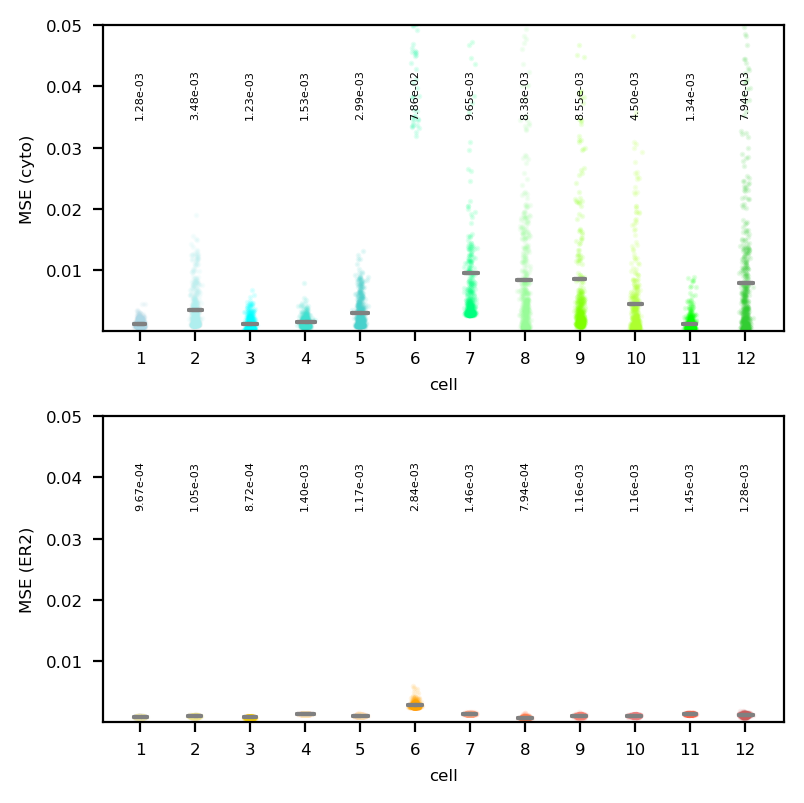

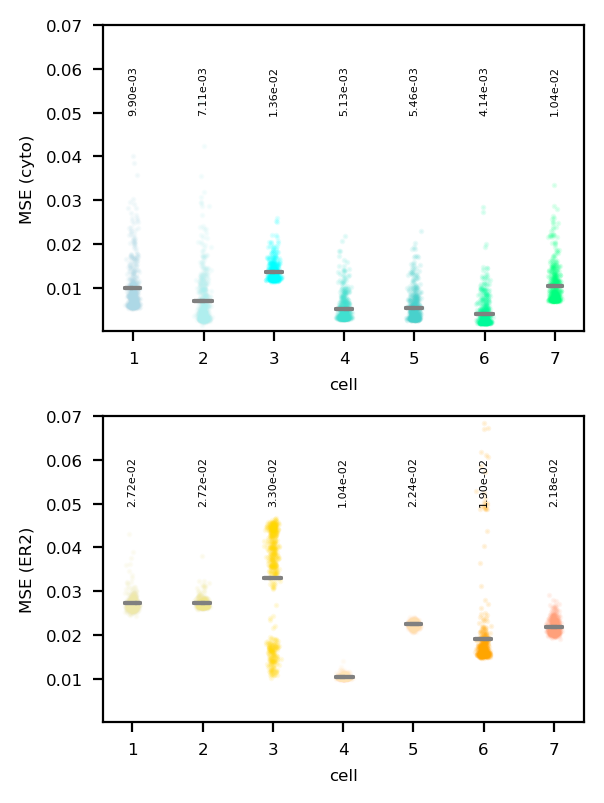

In [19]:
rcParams['font.size']=6
rcParams['figure.dpi']=200
ylabels=['cyto','ER2']
#bootstrapping
nIter=500
nSample=20

for i,key1 in enumerate(mses.keys()):
    if key1=='sim':
        rcParams['figure.figsize']=4,4
    else:
        rcParams['figure.figsize']=3,4
        
    fig=plt.figure()
    n=nCells[key1]
    
    for j,key2 in enumerate(mses[key1].keys()):
        ax=fig.add_subplot(2,1,j+1)
        ax.set_xlabel('cell')
        ax.set_xticks(np.arange(n+1))
        ax.set_ylabel('MSE ({})'.format(ylabels[j]))
        if key1 == 'sim':
            ax.set_ylim([0.00005, 0.05])
            yloc=0.035
        else:
            ax.set_ylim([0.00005, 0.07])
            yloc=0.05
            
        vals=mses[key1][key2]
        for cell in range(n):
            ys=vals[cell]
            xs=np.random.normal(cell+1, 0.04, len(ys))
            if j == 0:
                ax.scatter(xs,ys,s=1,color=cell_cols1[cell],alpha=0.1)
            else:
                ax.scatter(xs,ys,s=1,color=cell_cols2[cell],alpha=0.1)
            
            # bootstrapping
            nData=len(ys)
            means=[]
            for k in range(nIter):
                draws=np.random.choice(ys,nSample)
                mean=np.mean(draws)
                means.append(mean)
            avg=np.mean(means)
            std=np.std(means)
            ax.plot(xs,np.repeat(avg,len(xs)),color='gray')
            ax.annotate(f"{avg:.2e}", xy=(cell+1, yloc),fontsize=4,
                horizontalalignment="center",rotation=90,
                       )

    plt.tight_layout()
    plt.gcf().savefig('model{}_mse_{}.png'.format(model,key1))